In [ ]:
# September 2023
# Data exploration and cleaning
# Violeta Berdejo-Espinola & Ákos Hájas

In [ ]:
%pip install levenshtein pandas

In [1]:
import re
import os
import pandas as pd

os.getcwd()

'/Users/uqvberde/Projects/classifier_spanish/scripts'

In [2]:
pd.set_option("display.max_rows", 150)

df_repo = pd.read_csv(
    "../datasets/from_repo/majom_september_pos_added.csv.gz",
    header=None,
    index_col=0,
    names=[
        "id",
        "title_spa",
        "journal_name",
        "pub_year",
        "country",
        "abstract_eng",
        "main_text_eng",
        "ci_eng",
        "abstract_spa",
        "main_text_spa",
        "ci_spa",
    ],
)

df_pos = pd.read_csv(
    "../datasets/from_translate/translatE_spanish_positives_71.csv", 
    encoding="utf-8",
    names=[
        "title_spa",
        'Publication_type',
        "journal_name",
        "abstract_spa",
        "label"
    ],
    skiprows=1
)

df_pos = df_pos.drop(["Publication_type"], axis=1)

print(len(df_repo), len(df_pos))

5771 71


# clean data

In [3]:
# remove unwanted documents in repo corpus

bad_title = df_repo["title_spa"].str.contains("In Memoriam|Editorial|Fe de erratas|FE DE ERRATA|ERRATA|aniversario|ARTÍCULO RETRACTADO")
bad_body = df_repo["main_text_spa"].str.contains("Texto completo disponible sólo en PDF|Full text available only in PDF format Texto completo disponible sólo en PDF")
             
df_repo = df_repo.dropna(subset=["title_spa", "abstract_spa", "main_text_spa", "journal_name"])
df_repo = df_repo[~bad_title | ~bad_body]

print(f"duplicated titles: {df_repo.title_spa.duplicated().sum()}")
print(f"duplicated indeces: {df_repo.index.has_duplicates}")
print(len(df_repo), len(df_pos))

duplicated titles: 0
duplicated indeces: False
5019 71


/var/folders/dz/szfgpm5s0tn_frclv0gl7m2c0000gr/T/ipykernel_10805/2716205016.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_repo = df_repo[~bad_title | ~bad_body]


In [4]:
# normalize titles and journal name in repo and pos

def normalize_title(title):
    title = re.sub("\s+", " ", title).capitalize().strip().replace(".", "")
    title = re.sub("\xa0", " ", title)
    return re.sub("\n{1,}", " ", title)

df_pos["title_spa"] = df_pos["title_spa"].apply(normalize_title)
df_repo["title_spa"] = df_repo["title_spa"].apply(normalize_title)
df_repo["journal_name"] = df_repo["journal_name"].apply(lambda name: name.capitalize().strip())

repo_titles = df_repo["title_spa"]
pos_titles = df_pos["title_spa"]

print(len(df_repo), len(df_pos))

5019 71


# similarity between titles

In [5]:
# find similarity between titles from df_repo and df_pos

from Levenshtein import ratio

# each item in ratios is one title from repo mapped to similarity of all titles from the positives
ratios = repo_titles.map(lambda title_repo: pos_titles.map(lambda title_pos: ratio(title_pos, title_repo)))
# ratios[1:2:4]

# checking ratios
similarity = ratios.map(lambda ratio: ratio > 0.82)

# reduce the pos boolean to one by checking if _any_ of them is true -> a match between repo title and pos title
matches = similarity.map(lambda ratios: ratios.any()) #if any is TRUE

print(len(similarity), len(similarity.iloc[0]))
print(len(matches))
print(len(df_repo), len(df_pos))

5019 71
5019
5019 71


In [6]:
# checking if all positive titles are in matches

pos_matches = similarity.iloc[0]

for row in similarity[1:]:
    pos_matches += row

print(len(df_pos[~pos_matches]))
df_pos[~pos_matches]

# please read
# after inspection:
# indeces 12,17,45,48,61,66 are documents that are also available in English
# indeces 21,66 are not available online
# index 23 is a thesis
# thus can't be included

9


,title_spa,journal_name,abstract_spa,label
12,La liebre amenazada lepus flavigularis prefier...,Therya,Lepus flavigularis Wagner 1844 (Liebre de Tehu...,Positive
17,Murciélagos (mammalia: chiroptera) en áreas na...,Revista de Biología Tropical,"En general, los ambientes naturales se han tra...",Positive
21,Comprobación de un nuevo método para reducir l...,Ardeola,En las poblaciones naturales de aves los pollu...,Positive
22,Biología de la conservación del cisne coscorob...,Ardeola,Al final del resumen se explica la implementac...,Positive
45,Almacenamiento en frío del esperma de la truch...,Revista Mexicana de Biodiversidad,Con el objetivo de determinar un protocolo apr...,Positive
48,Éxito o fracaso: el papel de la restauración e...,Revista Mexicana de Biodiversidad,Estudios recientes han mostrado que la restaur...,Positive
61,Incubación artificial de huevo del pavón cornu...,Acta Zoológica Mexicana,La incubación artificial es una técnica favora...,Positive
65,Primera prueba de control de chaqueta amarilla...,BioScriba,La avispa exótica Vespula germanica (F.) es un...,Positive
66,Germinación de tres especies de fabaceae de in...,Quebracho,Grandes áreas del Monte Austral han sido sever...,Positive


# merge data

In [7]:
# combine positives and repo dfs, drop duplicates, label positives and negatives

df_match = df_repo[matches][["title_spa","abstract_spa","main_text_spa","journal_name"]]
df_match['label'] = "1"

df_repo = df_repo[["title_spa","abstract_spa","main_text_spa","journal_name"]]
df_repo['label'] = ""

df_combined = pd.concat([df_match, df_repo])
df_combined = df_combined.drop_duplicates(subset=["title_spa"], keep="first")
df_combined['label'] = df_combined.label.replace('','0', regex = True)
df_combined['abstract_spa'] = df_combined['abstract_spa'].str.replace(r'Resumen', '', regex=True)

print(len(df_combined[df_combined['label'] == "positive"]))
print(len(df_combined[df_combined['label'] == "negative"]))
print(len(df_combined))

# df_combined.to_csv('../data/pos_neg.csv', encoding='utf-8')

0
0
5019


In [ ]:
df_pos

In [18]:
import statistics

row_len_sum = []
for row in df_repo['abstract_spa']:
    row_len = len(''.join([word for word in row]))
    row_len_sum.append(row) 
    # statistics.mean(row_len_sum.mean)

In [20]:
row_len_sum

['Resumen En México no existe una producción forestal autosuficiente. Esta situación requiere la mejora de los procesos que intervienen de manera integral en ella. Abies religiosa es el oyamel que más se aprovecha en los bosques de coníferas, y aporta valiosos dividendos económicos al sector industrial; por lo que es necesario implementar esquemas que lleven a su sostenibilidad. En el presente trabajo se determinó la cantidad de madera que se produce en las Zonas de Movimiento de Germoplasma (ZMG). El análisis determinó que la zona X.3 presentó la mayor cantidad, con 67.94 %; mientras que a X.1, X.2, XII.1 y XII.3 les correspondieron 32.06 %. Las zonas III.1, III.2, XII.4 y XII.5 no registraron producción maderable. Los resultados denotan que el máximo volumen se obtiene de la región localizada en la parte central del país; por lo tanto, es importante mantener e incrementar las actividades de fomento en la zona X.3, para perpetuar la especie y aprovecharla a través de otros servicios. 

In [21]:
statistics.mean(lens)

200.46662681809124

Text(0.5, 1.0, 'Document feature length')

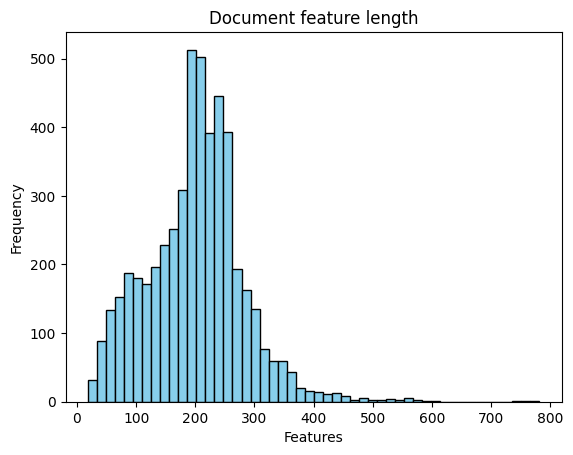

In [8]:
# length of documents
import matplotlib.pyplot as plt

lens = [len(document.split(" ")) for document in df_repo['abstract_spa']]

plt.hist(lens, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.title('Document feature length')